<a href="https://colab.research.google.com/github/javahedi/QuantumStateTomography-ML/blob/main/qst_ml_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Flatten, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import glob

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path= "/content/drive/MyDrive/SL_data/"
cvs_names = glob.glob(f'{path}*.csv')
data_list = []
for id, name in enumerate(cvs_names):
    data         = np.loadtxt( os.path.join(path,cvs_names[id]),delimiter=',',skiprows=1)
    data_list.append(data)
dataset = np.stack(data_list)
print(dataset.shape)
X,y=dataset[:,:,:3],dataset[:,:,3:]


(100, 99, 5)


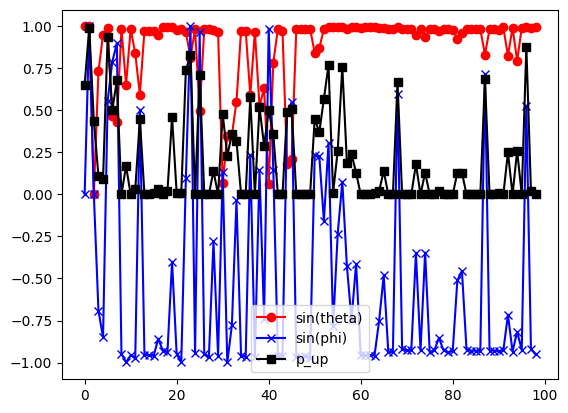

In [ ]:
plt.plot(np.sin(X[1,:,0]),'o-r',label='sin(theta)')
plt.plot(np.sin(X[1,:,1]),'x-b',label='sin(phi)')
plt.plot(X[1,:,2],'s-k',label='p_up')
plt.legend()
plt.show()

In [ ]:
d_model   = 64  # Adjust this according to your needs
num_heads = 4  # Adjust this according to your needs


In [ ]:
#class PermutationInvariantLayer(layers.Layer):
#    def __init__(self, **kwargs):
#        super(PermutationInvariantLayer, self).__init__(**kwargs)

#    def call(self, inputs):
#        # Assuming inputs has shape (batch_size, num_elements, num_features)
#        mean_across_elements = tf.reduce_mean(inputs, axis=1)
#        return mean_across_elements
'''
class PermutationInvariantLayer(tf.keras.Model):
    def __init__(self):
        super(PermutationInvariantLayer, self).__init__()
        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.attention = layers.MultiHeadAttention(
              num_heads=num_heads, key_dim=d_model // num_heads
            )
        self.flatten = layers.Flatten()  # Add a Flatten layer
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs, training=None, mask=None):
        attention_output = self.attention(inputs, inputs)
        flattened_output = self.flatten(attention_output)  # Flatten the output
        pooled_output = self.pooling(flattened_output)
        return pooled_output
'''

# Permutation Invariance
class PermutationInvariantLayer(tf.keras.Model):
    def __init__(self):
        super(PermutationInvariantLayer, self).__init__()

        # Ensure d_model is divisible by num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.attention = layers.MultiHeadAttention(
              num_heads=num_heads, key_dim=d_model // num_heads
            )
        self.pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs, training=None, mask=None):
        attention_output = self.attention(inputs, inputs)
        pooled_output    = self.pooling(attention_output)
        return pooled_output


In [ ]:
#Define the custom probability function
def probability(y_pred):
    # Replace this with the actual logic
    p_out = tf.math.reduce_sum(y_pred, axis=1, keepdims=False, name=None)
    return p_out

def custom_loss(y_true, y_pred, lambda_weight=0.8):
    # Assuming y_true has shape (batch_size, 3) and y_pred has shape (batch_size, 2)
    y_true_values = y_true[:, :2]  # Extracting the target values from y_true
    y_pred_values = y_pred  # Adjust this based on your model's output structure


    # Assuming pro_true and pro_predict are the probabilities for comparison
    pro_true    = y_true[:, 2]
    pro_predict = probability(y_pred)  # Define how to get pro_predict from y_pred

    # Calculate MSE for target values
    mse_target = tf.keras.losses.mean_squared_error(y_true_values, y_pred_values)

    # Calculate MSE for probabilities
    mse_prob = tf.keras.losses.mean_squared_error(pro_true, pro_predict)

    # Combine both losses with an appropriate weighting factor
    total_loss = mse_target + lambda_weight * mse_prob

    return total_loss


In [ ]:
# Example test case
batch_size = 32
num_targets = 2
num_samples = batch_size

# Generate random test data
y_true_test = tf.random.normal((batch_size, num_targets + 1))  # Assuming 3 targets (2 values + 1 probability)
y_pred_test = tf.random.normal((batch_size, num_targets))  # Assuming 2 predicted values
print(y_true_test.shape)
print(y_pred_test.shape)
# Call the custom loss function
loss_value = custom_loss(y_true_test, y_pred_test)

# Print the input and output dimensions
print(f"Input (y_true) shape: {y_true_test.shape}")
print(f"Input (y_pred) shape: {y_pred_test.shape}")
print(f"Output (loss) value: {loss_value.numpy()}")

(32, 3)
(32, 2)
Input (y_true) shape: (32, 3)
Input (y_pred) shape: (32, 2)
Output (loss) value: [ 3.057597  11.2116165  4.685129   4.0832953  2.5129144  3.1300788
  2.4459698  4.069217   3.034415   3.0753596  6.406167   4.933648
  2.5736027  4.1338577  8.102466   4.074588   2.599711   2.5789366
  2.7909105  3.332717   2.5528178  6.8987303  2.2881634  4.685507
  6.8396864  4.080173   2.6299841  6.319954   2.7269747  2.341042
  2.8837066  2.509225 ]


In [ ]:

# Assuming your input data has three features (theta, phi, p_up)
num_samples     = X.shape[0]
sequence_length = X.shape[1]
input_dim       = X.shape[2]

In [ ]:
# test
np.random.seed(42)
X        = np.random.rand(num_samples, sequence_length, input_dim)
y        = np.random.rand(num_samples, 2)
pro_true = np.random.rand(num_samples)


# Combine y and pro_true to create the target variable y_true
y_true = np.concatenate([y, pro_true.reshape(-1, 1)], axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)


In [ ]:
# Use tf.data.Dataset for batching and shuffling
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=num_samples).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# Assuming you have created the train_dataset using tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=num_samples).batch(batch_size)

# Check the first few batches in the train_dataset
for batch in train_dataset.take(2):  # Adjust the number as needed
    X_batch, y_batch = batch
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)


X_batch shape: (32, 99, 3)
y_batch shape: (32, 3)
X_batch shape: (32, 99, 3)
y_batch shape: (32, 3)


In [ ]:
'''

# Input layer
input_layer = Input(shape=(sequence_length, input_dim))

# LSTM layer to capture temporal dependencies
# The LSTM layer serves as a feature extractor,
# transforming the input sequence into a representation that captures
# relevant temporal patterns. This representation is then used as input
# to subsequent layers for further processing
lstm_layer = LSTM(64, activation='relu', return_sequences=True)(input_layer)

# Permutation invariant layer
perm_inv_layer = PermutationInvariantLayer()(lstm_layer)

# Dense forward network
dense_layer_1 = Dense(64, activation='relu')(perm_inv_layer)
output_layer = Dense(2, activation='linear')(dense_layer_1)

# Build the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss=custom_loss)
'''

"\n\n# Input layer\ninput_layer = Input(shape=(sequence_length, input_dim))\n\n# LSTM layer to capture temporal dependencies\n# The LSTM layer serves as a feature extractor, \n# transforming the input sequence into a representation that captures \n# relevant temporal patterns. This representation is then used as input \n# to subsequent layers for further processing\nlstm_layer = LSTM(64, activation='relu', return_sequences=True)(input_layer)\n\n# Permutation invariant layer\nperm_inv_layer = PermutationInvariantLayer()(lstm_layer)\n\n# Dense forward network\ndense_layer_1 = Dense(64, activation='relu')(perm_inv_layer)\noutput_layer = Dense(2, activation='linear')(dense_layer_1)\n\n# Build the model\nmodel = tf.keras.Model(inputs=input_layer, outputs=output_layer)\n\n# Compile the model with an appropriate optimizer and loss function\nmodel.compile(optimizer='adam', loss=custom_loss)\n"

In [ ]:
# Use the Sequential API for a more modular model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True,
        input_shape=(sequence_length, input_dim)),
    PermutationInvariantLayer(),
    Dense(64, activation='relu'),
    Dense(2, activation='linear')
])

# Use a built-in loss function
model.compile(optimizer='adam', loss=custom_loss)



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 99, 64)            17408     
                                                                 
 permutation_invariant_laye  (None, 64)                16640     
 r_2 (PermutationInvariantL                                      
 ayer)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 38338 (149.76 KB)
Trainable params: 38338 (149.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
'''
# Use tf.distribute.MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)),
        PermutationInvariantLayer(),
        Dense(64, activation='relu'),
        Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
'''

"\n# Use tf.distribute.MirroredStrategy for multi-GPU training\nstrategy = tf.distribute.MirroredStrategy()\nwith strategy.scope():\n    model = Sequential([\n        LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, input_dim)),\n        PermutationInvariantLayer(),\n        Dense(64, activation='relu'),\n        Dense(2, activation='linear')\n    ])\n    model.compile(optimizer='adam', loss='mse')\n"

Epoch 1/10
3/3 [==============================] - 5s 401ms/step - loss: 0.5006 - val_loss: 0.4514
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 1s 232ms/step - loss: 0.3386 - val_loss: 0.2575
Epoch 3/10
3/3 [==============================] - 1s 167ms/step - loss: 0.2253 - val_loss: 0.1849
Epoch 4/10
3/3 [==============================] - 0s 114ms/step - loss: 0.2412 - val_loss: 0.1820
Epoch 5/10
3/3 [==============================] - 0s 97ms/step - loss: 0.2211 - val_loss: 0.1905
Epoch 6/10
3/3 [==============================] - 0s 102ms/step - loss: 0.2106 - val_loss: 0.2127
Epoch 7/10
3/3 [==============================] - 0s 112ms/step - loss: 0.2134 - val_loss: 0.2052
Epoch 8/10
3/3 [==============================] - 0s 112ms/step - loss: 0.2084 - val_loss: 0.1860
Epoch 9/10
3/3 [==============================] - 0s 131ms/step - loss: 0.2061 - val_loss: 0.1777
Epoch 10/10
3/3 [==============================] - 0s 111ms/step - loss: 0.2080 - val_loss: 0.1786


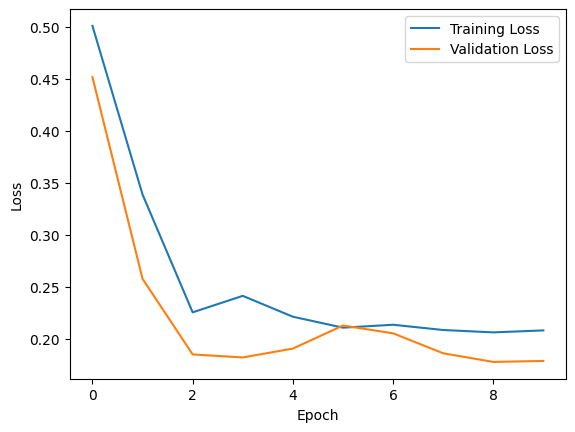

In [ ]:
num_epochs = 10
batch_size = 32


# Define callback functions
# Use distributed callbacks if using tf.distribute.MirroredStrategy
callbacks = [
    ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True),
    EarlyStopping(patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')
]

# Assuming X_train, y_true_train, X_val, y_true_val are your training and validation data
# Train the model with the tf.data.Dataset
history = model.fit(train_dataset, epochs=num_epochs,
                    validation_data=val_dataset, callbacks=callbacks)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
